<a href="https://colab.research.google.com/github/yashveersinghsohi/OCR_HandWritten_Form/blob/master/Model/Handwritten_Text_Recognition_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Packages

In [34]:
# Data Wrangling
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt

# Dataset
from tensorflow.keras.datasets import mnist

# Models and reports
from tensorflow.keras.optimizers import SGD
from keras.models import model_from_json
from sklearn.metrics import classification_report
import h5py

# Image Processing
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import build_montages

# Helper Functions

## Functions to Import Data

### Importing data for characters and digits

This function takes in the file path and returns the dataset of characters downloaded from [kaggle](https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format) 

In [2]:
def load_az_data(path):
  df = pd.read_csv(path, header = None)
  
  labels = df[0].values
  data = df.drop([0], axis = 1).values
  data = data.reshape((-1, 28, 28))

  labels = labels.astype(np.uint8)
  data = data.astype(np.float32)

  return (data, labels)

### Importing data for digits

This function loads the popular MNIST dataset. The dataset is loaded in keras and hence nothing additional needs to be downloaded

In [3]:
def load_mnist_data():
  ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
  
  data = np.vstack([trainData, testData])
  labels = np.hstack([trainLabels, testLabels])
  
  return (data, labels)

## Data Preperation

### Combining the imported datasets 

This function is used to combine the characters a-z dataset from kaggle and the numbers MNIST dataset from keras.

In [4]:
def combine_sets(az_path):
  az_data, az_labels = load_az_data(az_path)
  mnist_data, mnist_labels = load_mnist_data()

  az_labels = az_labels + 10

  data = np.vstack([az_data, mnist_data])
  labels = np.hstack([az_labels, mnist_labels])

  data = [cv2.resize(img, (32, 32)) for img in data]
  data = np.array(data, dtype = np.float32)
  
  data = np.expand_dims(data, axis = -1)
  data = data / 255.0

  return (data, labels)

## RESNET Implementation

This RESNET implementation is taken verbatum from this [pyimagesearch blog](https://www.pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/)

In [5]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and then apply a BN followed by CONV
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)
		x = Conv2D(filters[0], (3, 3), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

# Data

In [6]:
path = "/content/drive/MyDrive/OpenCV Tutorial/Handwritten Text Recognition/ocr-keras-tensorflow/a_z_handwritten_data.csv"

data, labels = combine_sets(path)

11493376/11490434 [==============================] - 0s 0us/step


# Preprocessing

## One Hot Encoding Labels

Using LabelBinarizer from sklearn to encode the labels

In [7]:
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

## Class Weights

Account for class imbalance

In [8]:
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Train-Test Split

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.20, stratify=labels, 
                                                  random_state=42)

## Image Augmentor

Defining **ImageDataGenerator** object for data augmentation 

In [10]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

# RESNET Model

## Initializing Model

In [13]:
EPOCHS = 10
INIT_LR = 1e-1
BS = 128

opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

## Model Fit

In [14]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

Epoch 1/10
2765/2765 [==============================] - 149s 53ms/step - loss: 4.2502 - accuracy: 0.7531 - val_loss: 0.5012 - val_accuracy: 0.9139
Epoch 2/10
2765/2765 [==============================] - 146s 53ms/step - loss: 1.1282 - accuracy: 0.9163 - val_loss: 0.5157 - val_accuracy: 0.8979
Epoch 3/10
2765/2765 [==============================] - 146s 53ms/step - loss: 1.0419 - accuracy: 0.9232 - val_loss: 0.5550 - val_accuracy: 0.8776
Epoch 4/10
2765/2765 [==============================] - 147s 53ms/step - loss: 1.0060 - accuracy: 0.9267 - val_loss: 0.5629 - val_accuracy: 0.8749
Epoch 5/10
2765/2765 [==============================] - 148s 54ms/step - loss: 0.9631 - accuracy: 0.9288 - val_loss: 0.5508 - val_accuracy: 0.8807
Epoch 6/10
2765/2765 [==============================] - 146s 53ms/step - loss: 0.9396 - accuracy: 0.9303 - val_loss: 0.5603 - val_accuracy: 0.8780
Epoch 7/10
2765/2765 [==============================] - 148s 53ms/step - loss: 0.9354 - accuracy: 0.9308 - val_loss: 0

## Model Performance

In [15]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

           0       0.15      0.95      0.26      1381
           1       0.98      0.98      0.98      1575
           2       0.87      0.97      0.92      1398
           3       0.95      0.99      0.97      1428
           4       0.85      0.97      0.90      1365
           5       0.48      0.94      0.63      1263
           6       0.91      0.98      0.94      1375
           7       0.94      0.98      0.96      1459
           8       0.84      0.99      0.91      1365
           9       0.96      0.99      0.97      1392
           A       0.99      0.98      0.99      2774
           B       0.98      0.97      0.97      1734
           C       0.99      0.97      0.98      4682
           D       0.93      0.96      0.94      2027
           E       0.99      0.98      0.98      2288
           F       0.95      0.99      0.97       232
           G       0.95      0.93      0.94      1152
           H       0.98    

## Save Model to Disk

In [19]:
# Save Model Definition
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save Model Weights
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Visualizing Performance

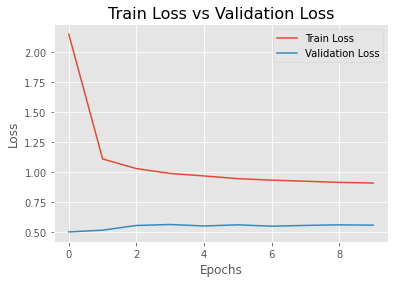

In [30]:
plt.plot(H.history["loss"], label = "Train Loss")
plt.plot(H.history["val_loss"], label = "Validation Loss")

plt.title("Train Loss vs Validation Loss", size = 16)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()